In [1]:
from numba.experimental import jitclass
from numba import njit, float64
from pylab import np, plt
plt.style.use('ggplot')

In [8]:
@jitclass(
    spec=[
        ('tsim_machine', float64),
        ('tsim_controller',float64),
        ('tsim_stop',float64),
        ('I_2x2',float64[:,:]),
        ('J_2x2',float64[:,:]),
    ]
)
class SimParam:
    def __init__(self,tsim_machine,tsim_controller,tsim_stop):
        self.tsim_machine = tsim_machine
        self.tsim_controller = tsim_controller
        self.tsim_stop = tsim_stop
        self.I_2x2 = np.eye(2,dtype=np.float64)
        self.J_2x2 = np.array([[0,-1],[1,0]],dtype=np.float64)

@jitclass(
    spec=[
        ('Rs', float64),
        ('Ld',float64),
        ('Lq',float64),
        ('Lmat',float64[:,:]),
        ('Lmat_inv',float64[:,:]),
        ('PsiPM',float64),
        ('OmegaE',float64),
        ('ThetaE',float64),
        
        ('udq',float64[:,:]),
        ('idq',float64[:,:]),

        ('uab',float64[:,:]),
        ('iab',float64[:,:]),
        ('eab',float64[:,:]),
    ]
)
class ACMachineSM:
    def __init__(self,
                 init_Rs = 0.8,
                 init_Ld = 1.6e-3,
                 init_Lq = 1.6e-3,
                 init_PsiPM = 0.063,
                 init_OmegaE = 2 * np.pi * 50):
        self.Rs = init_Rs
        self.Ld = init_Ld
        self.Lq = init_Lq
        self.Lmat = np.array([[self.Ld,0],[0,self.Lq]],dtype=np.float64)
        self.Lmat_inv = np.array([[1/self.Ld,0],[0,1/self.Lq]],dtype=np.float64)

        self.PsiPM = init_PsiPM
        self.OmegaE = init_OmegaE
        self.ThetaE = 0.0

        self.udq = np.zeros((2,1),dtype=np.float64)
        self.idq = np.zeros((2,1),dtype=np.float64)

        self.uab = np.zeros((2,1),dtype=np.float64)
        self.iab = np.zeros((2,1),dtype=np.float64)
        self.eab = np.zeros((2,1),dtype=np.float64)

        

@jitclass(
    spec=[
        ('CMD_UDQ_0',float64[:,:]),
        ('CMD_IDQ_0',float64[:,:]),
        ('CMD_UDQ_TOTAL',float64[:,:]),
        ('INJ_UDQ_HF',float64[:,:]),
        ('CMD_UAB',float64[:,:]),
        ('CMD_umdh',float64),
        ('CMD_umqh',float64),
        ('CMD_psi_dh',float64),
        ('CMD_psi_qh',float64),
        ('ThetaH',float64),
        ('OmegaH',float64),
    ]
)
class DSPController:
    def __init__(self,
                 CMD_id0 = -4.0,
                 CMD_iq0 = 4.0,
                 CMD_umdh = 2.0,
                 CMD_umqh = 2.0,
                 CMD_psi_dh = 0.0,
                 CMD_psi_qh = np.pi * 0.5,
                 OmegaH = 2 * np.pi * 100):
        self.CMD_UDQ_0 = np.zeros((2,1),dtype=np.float64)
        self.CMD_IDQ_0 = np.array([[CMD_id0],[CMD_iq0]],dtype=np.float64)
        self.CMD_UDQ_TOTAL = np.zeros((2,1),dtype=np.float64)
        self.INJ_UDQ_HF = np.zeros((2,1),dtype=np.float64)
        self.CMD_UAB = np.zeros((2,1),dtype=np.float64)

        self.CMD_umdh = CMD_umdh
        self.CMD_umqh = CMD_umqh
        self.CMD_psi_dh = CMD_psi_dh
        self.CMD_psi_qh = CMD_psi_qh
        self.ThetaH = 0.0
        self.OmegaH = OmegaH


@jitclass(
    spec=[
        ('iab_hat',float64[:,:]),
        ('eab_hat',float64[:,:]),
        ('k',float64),
        ('eta',float64),
        ('Rs_hat',float64),
        ('Lq_hat',float64),
        ('k_Rs',float64),
        ('k_Lq',float64),
    ]
)
class FSOParam:
    def __init__(self,k,eta,k_Rs,k_Lq,init_Rs,init_Lq):
        self.iab_hat = np.zeros((2,1),dtype=np.float64)
        self.eab_hat = np.zeros((2,1),dtype=np.float64)
        
        self.k = k
        self.eta = eta
        self.Rs_hat = init_Rs
        self.Lq_hat = init_Lq
        self.k_Rs = k_Rs
        self.k_Lq = k_Lq


@njit(nogil=True)
def Park2Clark(dq,ThetaE):
    ab = np.zeros((2,1),dtype=np.float64)
    ab[0,0] = dq[0,0] * np.cos(ThetaE) - dq[1,0] * np.sin(ThetaE)
    ab[1,0] = dq[0,0] * np.sin(ThetaE) + dq[1,0] * np.cos(ThetaE)
    return ab

@njit(nogil=True)
def matrix_dot(mat1,mat2):
    s = 0
    mat = np.empty(shape=(mat1.shape[0], mat2.shape[1]), dtype=mat1.dtype)
    for i in range(mat1.shape[0]):
        for j in range(mat2.shape[1]):
            s = 0
            for k in range(mat2.shape[0]):
                s += mat1[i,k] * mat2[k,j]
            mat[i,j] = s
    return mat

@njit(nogil=True)
def ODE_Machine_1st(simparam:SimParam,smparam:ACMachineSM,ctrlparam:DSPController):
    smparam.udq = ctrlparam.CMD_UDQ_TOTAL
    psidq = np.array([[0.0],[smparam.PsiPM * smparam.OmegaE]])
    psidq += matrix_dot(smparam.Lmat,smparam.idq)
    idq_dot = smparam.udq - smparam.Rs * smparam.idq - smparam.OmegaE * matrix_dot(simparam.J_2x2,psidq)
    idq_dot = matrix_dot(smparam.Lmat_inv,idq_dot)
    smparam.idq += idq_dot * simparam.tsim_machine
    smparam.ThetaE += smparam.OmegaE * simparam.tsim_machine
    return smparam

@njit(nogil=True)
def ODE_Machine_2nd(simparam:SimParam,smparam:ACMachineSM,ctrlparam:DSPController):
    smparam.udq = ctrlparam.CMD_UDQ_TOTAL
    smparam.uab = Park2Clark(smparam.udq,smparam.ThetaE)
    smparam.iab = Park2Clark(smparam.idq,smparam.ThetaE)
    A = np.array([[-smparam.Rs,smparam.OmegaE * smparam.Lq],[-smparam.OmegaE * smparam.Ld,-smparam.Rs]],dtype=np.float64)
    A = matrix_dot(smparam.Lmat_inv,A)
    B = smparam.Lmat_inv
    Psi = simparam.I_2x2 + simparam.tsim_machine * A + 0.5 * (simparam.tsim_machine)**2 * matrix_dot(A,A)
    G   = simparam.I_2x2 * simparam.tsim_machine     + (simparam.tsim_machine)**2 * A
    G = matrix_dot(G,B)
    # edq = np.zeros((2,1),dtype=np.float64)
    # edq[1,0] = smparam.PsiPM * smparam.OmegaE
    # smparam.idq = matrix_dot(Psi,smparam.idq) + matrix_dot(G,smparam.udq) - matrix_dot(G,edq)
    smparam.idq = matrix_dot(Psi,smparam.idq) + matrix_dot(G,smparam.udq) - matrix_dot(G,np.array([[0.0],[smparam.PsiPM * smparam.OmegaE]]))
    e_am = smparam.OmegaE * (smparam.PsiPM + (smparam.Ld - smparam.Lq) * smparam.idq[0,0])
    edq = np.array([[0.0],[e_am]],dtype=np.float64)
    smparam.eab = Park2Clark(edq,smparam.ThetaE)
    smparam.ThetaE += smparam.OmegaE * simparam.tsim_machine
    
    return smparam

@njit(nogil=True)
def DSP_HFI(simparam:SimParam,smparam:ACMachineSM,ctrlparam:DSPController):
    temp = matrix_dot(simparam.J_2x2,smparam.Lmat)
    ctrlparam.CMD_UDQ_0 = smparam.Rs * ctrlparam.CMD_IDQ_0 + smparam.OmegaE * (matrix_dot(temp,ctrlparam.CMD_IDQ_0) + np.array([[0.0],[smparam.PsiPM]]))
    ctrlparam.INJ_UDQ_HF[0,0] = ctrlparam.CMD_umdh * np.sin(ctrlparam.ThetaH)
    ctrlparam.INJ_UDQ_HF[1,0] = ctrlparam.CMD_umqh * np.cos(ctrlparam.ThetaH)
    ctrlparam.ThetaH += ctrlparam.OmegaH * simparam.tsim_controller
    
    ctrlparam.CMD_UDQ_TOTAL = ctrlparam.CMD_UDQ_0 + ctrlparam.INJ_UDQ_HF
    ctrlparam.CMD_UAB = Park2Clark(ctrlparam.CMD_UDQ_TOTAL,smparam.ThetaE)
    return ctrlparam

@njit(nogil=True)
def FSO(simparam:SimParam,smparam:ACMachineSM,ctrlparam:DSPController,fsoparam:FSOParam):
    AI = np.array([[-fsoparam.Rs_hat/fsoparam.Lq_hat,0.0],[0.0,-fsoparam.Rs_hat/fsoparam.Lq_hat]])
    BI = (1/fsoparam.Lq_hat) * simparam.I_2x2
    PsiI_I = simparam.I_2x2 + simparam.tsim_controller * AI + 0.5 * ((simparam.tsim_controller)**2) * matrix_dot(AI,AI)
    GI_U = simparam.I_2x2 * simparam.tsim_controller + 0.5 * (simparam.tsim_controller)**2 * AI + 0.1667 * (simparam.tsim_controller)**3 * matrix_dot(AI,AI)
    GI_U = matrix_dot(GI_U,BI)
    GI_E = -GI_U
    GI_K = GI_U * fsoparam.k

    X_hat = fsoparam.iab_hat;X = smparam.iab;U = ctrlparam.CMD_UAB;E_hat = fsoparam.eab_hat
    X_tilde = X_hat - X
    X_sgn = np.sign(X_tilde)
    X_hat_next = matrix_dot(PsiI_I,X_hat) + matrix_dot(GI_E,E_hat) + matrix_dot(GI_U,U) + matrix_dot(GI_K,X_sgn)
    X_hat_dot = matrix_dot(AI,X_hat) + matrix_dot(BI,U) - matrix_dot(BI,E_hat)
    Rs_hat_dot = fsoparam.k_Rs * (matrix_dot(X_tilde.T,X_hat))
    Lq_hat_dot = fsoparam.k_Lq * (matrix_dot(X_tilde.T,X_hat_dot))

    AE = np.array([[0.0,-smparam.OmegaE],[smparam.OmegaE,0.0]])
    T = fsoparam.k * np.array([[fsoparam.eta,smparam.OmegaE],[-smparam.OmegaE,fsoparam.eta]])
    PsiE_E = simparam.I_2x2 + simparam.tsim_controller * AE + 0.5 * (simparam.tsim_controller)**2 * matrix_dot(AE,AE)
    GE_T = simparam.I_2x2 * simparam.tsim_controller + 0.5 * (simparam.tsim_controller)**2 * AE + 0.1667 * (simparam.tsim_controller)**3 * matrix_dot(AE,AE)
    GE_T = matrix_dot(GE_T,T)
    E_hat_next = matrix_dot(PsiE_E,E_hat) + matrix_dot(GE_T,X_sgn)

    fsoparam.Rs_hat += Rs_hat_dot[0,0] * simparam.tsim_controller + Rs_hat_dot[0,0]**2 * simparam.tsim_controller**2
    fsoparam.Lq_hat += Lq_hat_dot[0,0] * simparam.tsim_controller + Lq_hat_dot[0,0]**2 * simparam.tsim_controller**2

    if(fsoparam.Rs_hat > smparam.Rs * 2):
        fsoparam.Rs_hat = smparam.Rs * 2
    elif(fsoparam.Rs_hat < smparam.Rs * 0.5):
        fsoparam.Rs_hat = smparam.Rs * 0.5
    
    if(fsoparam.Lq_hat > smparam.Lq * 2):
        fsoparam.Lq_hat = smparam.Lq * 2
    elif(fsoparam.Lq_hat < smparam.Lq * 0.5):
        fsoparam.Lq_hat = smparam.Lq * 0.5
    
    fsoparam.iab_hat = X_hat_next
    fsoparam.eab_hat = E_hat_next
    return fsoparam

@njit(nogil=True)
def ACMSimPyIncremental(simparam:SimParam,smparam:ACMachineSM,ctrlparam:DSPController,fsoparam:FSOParam):
    down_sampling = int(simparam.tsim_controller/simparam.tsim_machine)
    machine_times = np.arange(0,simparam.tsim_stop,simparam.tsim_machine)
    ctrl_times = np.arange(0,simparam.tsim_stop,simparam.tsim_controller)
    # watch_data_machine = np.zeros((13, len(machine_times)))
    watch_data_ctrl    = np.zeros((12,  len(ctrl_times   )))
    jj = 0; watch_index_machine = 0; watch_index_ctrl = 0
    for ii in range(len(machine_times)):
        t = machine_times[ii]
        jj += 1
        if jj >= down_sampling:
            jj = 0
            ctrlparam = DSP_HFI(simparam,smparam,ctrlparam)
            fsoparam = FSO(simparam,smparam,ctrlparam,fsoparam)
            watch_data_ctrl[0 ][watch_index_ctrl] = fsoparam.iab_hat[0,0]
            watch_data_ctrl[1 ][watch_index_ctrl] = fsoparam.iab_hat[1,0]
            watch_data_ctrl[2 ][watch_index_ctrl] = smparam.iab[0,0]
            watch_data_ctrl[3 ][watch_index_ctrl] = smparam.iab[1,0]
            watch_data_ctrl[4 ][watch_index_ctrl] = fsoparam.eab_hat[0,0]
            watch_data_ctrl[5 ][watch_index_ctrl] = fsoparam.eab_hat[1,0]
            watch_data_ctrl[6 ][watch_index_ctrl] = smparam.eab[0,0]
            watch_data_ctrl[7 ][watch_index_ctrl] = smparam.eab[1,0]
            watch_data_ctrl[8 ][watch_index_ctrl] = fsoparam.Rs_hat
            watch_data_ctrl[9 ][watch_index_ctrl] = fsoparam.Lq_hat
            watch_data_ctrl[10][watch_index_ctrl] = smparam.idq[0,0]
            watch_data_ctrl[11][watch_index_ctrl] = smparam.idq[1,0]
            watch_index_ctrl += 1
        smparam = ODE_Machine_2nd(simparam,smparam,ctrlparam)
    return ctrl_times,watch_data_ctrl


In [9]:
simparam = SimParam(
    tsim_machine=1e-5,
    tsim_controller=1e-4,
    tsim_stop = 10,
)
spmsm_2nd = ACMachineSM(
                 init_Rs = 0.8,
                 init_Ld = 1.6e-3,
                 init_Lq = 1.6e-3,
                 init_PsiPM = 0.054,
                 init_OmegaE = 2 * np.pi * 40)
ctrl = DSPController(
    CMD_id0 = -4,
    CMD_iq0 = 4,
    CMD_umdh = 1,
    CMD_umqh = 1,
    CMD_psi_dh = 0.0,
    CMD_psi_qh = 0.0,
    OmegaH = 2 * np.pi * 200)
fsoparam = FSOParam(
    k = -0.08,
    eta = -0.5,
    k_Rs = 20,
    k_Lq = 1e-4,
    init_Rs = spmsm_2nd.Rs,
    init_Lq = spmsm_2nd.Lq
)
ctrl_times,watch_data_ctrl = ACMSimPyIncremental(simparam,spmsm_2nd,ctrl,fsoparam)



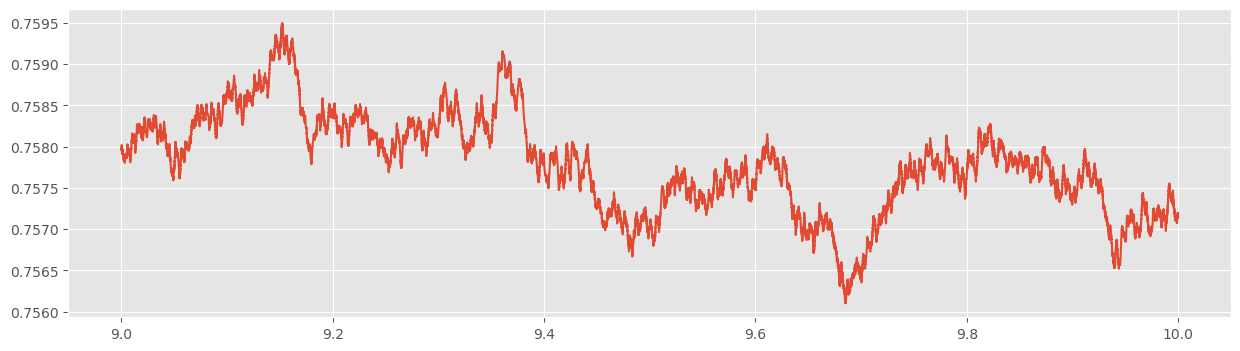

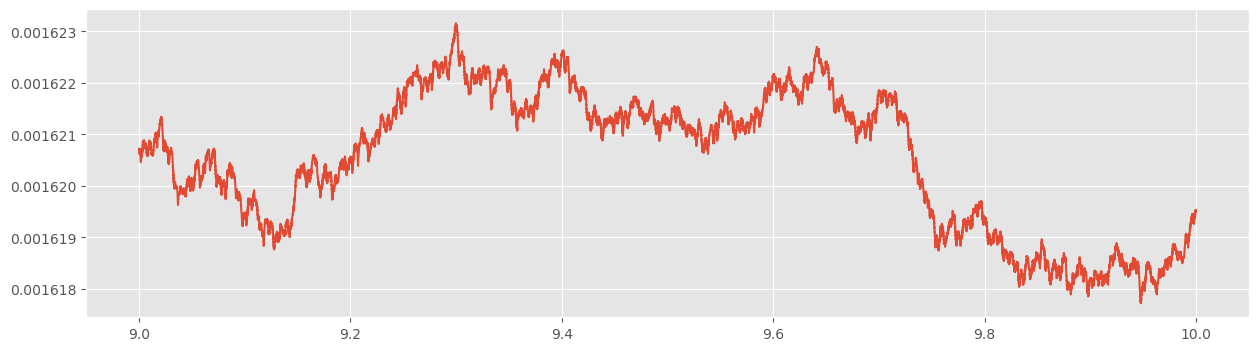

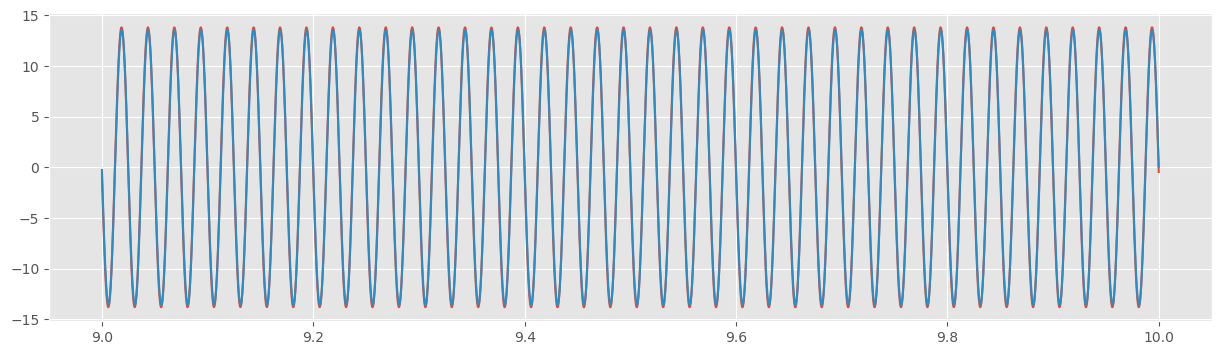

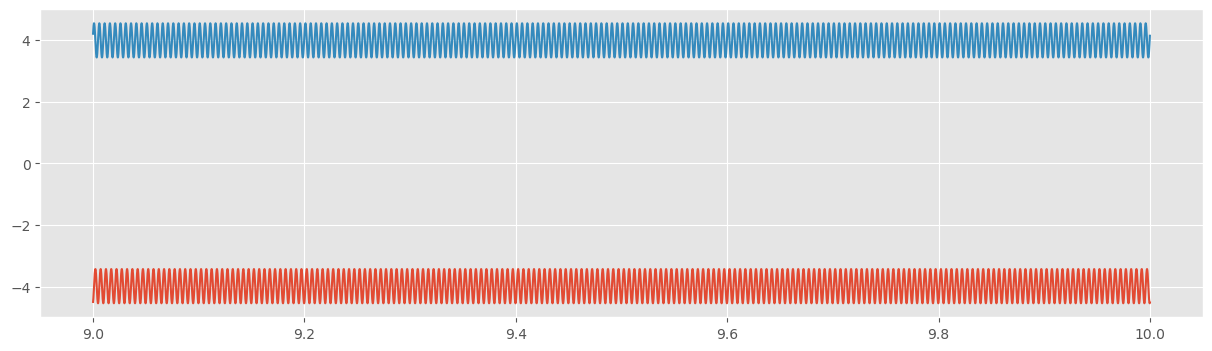

In [13]:
ctrl_plot_start_time = 9
ctrl_plot_stop_time = 10
start_index = int(ctrl_plot_start_time/simparam.tsim_controller)
end_index = int(ctrl_plot_stop_time/simparam.tsim_controller)
plt.figure(figsize=(15,4))
plt.plot(ctrl_times[list(range(start_index,end_index))],watch_data_ctrl[8][list(range(start_index,end_index))])
plt.show()
plt.figure(figsize=(15,4))
plt.plot(ctrl_times[list(range(start_index,end_index))],watch_data_ctrl[9][list(range(start_index,end_index))])
plt.show()

plt.figure(figsize=(15,4))
plt.plot(ctrl_times[list(range(start_index,end_index))],watch_data_ctrl[4][list(range(start_index,end_index))])
plt.plot(ctrl_times[list(range(start_index,end_index))],watch_data_ctrl[6][list(range(start_index,end_index))])
plt.show()